## 앙상블의 원리

In [93]:
def num(x):
    head = 0
    p = []
    for j in range(1, x+1):
        rand_num = np.random.rand(1)
        if rand_num < 0.51:
            head += 1
        p.append([head/j])
    return p

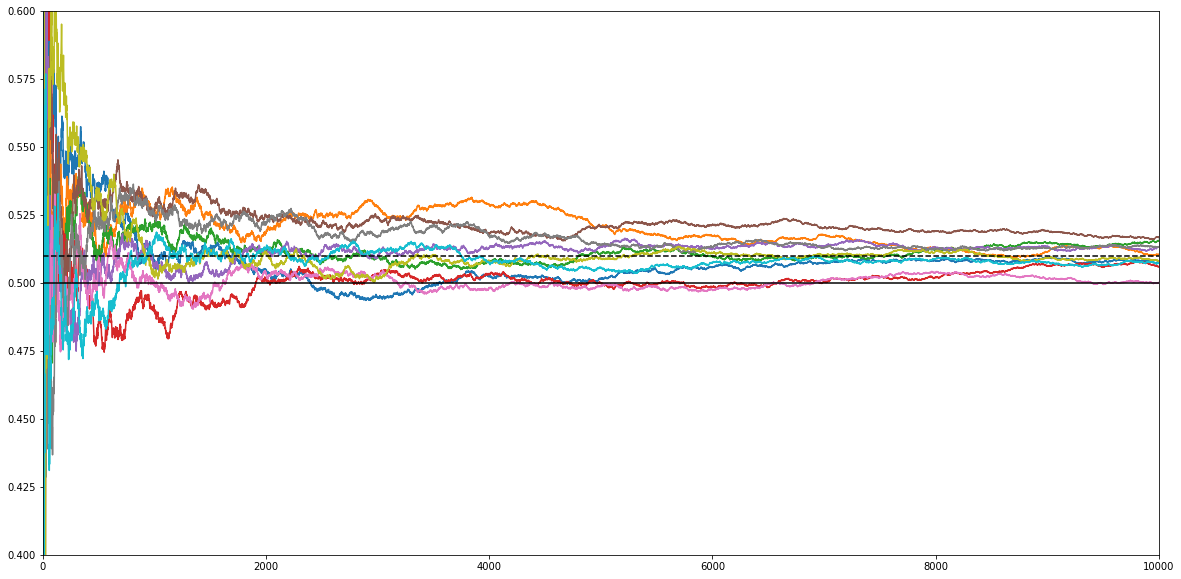

In [106]:
import matplotlib.pyplot as plt
try_num = 10000
plt.figure(figsize=(20,10))
for i in range(10):
    plt.plot(range(1, try_num+1), num(try_num))
plt.plot([0, try_num], [0.51, 0.51], 'k--')
plt.plot([0,try_num], [.5,.5], 'k-')
plt.xlim([0,try_num])
plt.ylim([0.4,.6])
plt.show()

#### 투표 기반 분류기

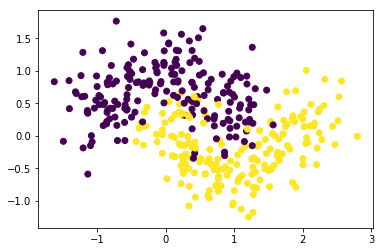

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
plt.scatter(X_train[:, 0], X_train[:,1], c=y_train)
plt.show()

In [163]:
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto')

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf), ('rf',rnd_clf),('svc',svm_clf)],
    voting='hard')

from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


#### 간접 투표 방식 (확률의 평균이 높은 걸 선택하는 방식)

In [161]:
svm_clf = SVC(gamma='auto', probability=True)
voting_clf = VotingClassifier(
    estimators=[('lr',log_clf), ('rf',rnd_clf),('svc',svm_clf)],
    voting='soft')
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


## 배깅

In [222]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), # 기반 분류기에 predict_proba() 함수가 있는 경우 간접 투표 방식을 사용한다.
    n_estimators=500,  # 500개의 하위 분류기를 만든다.
    max_samples=100,   # 각각의 하위 분류기가 학습할 샘플 수. 0~1 사이의 실수(float)를 골라도 된다. 
    # max_features는 특성 샘플링을 조절한다.
    bootstrap=True,    # 페이스팅을 하려면 False를 지정하면 된다.
    # bootstrap_features는 특성 샘플링의 복원추출 여부를 결정한다.
    n_jobs=-1,         # 기본값은 1. 사용할 CPU 코어 수를 지정한다.
    random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

#### oob score
out-of-bag sample

In [224]:
# BaggingClassifier의 max_samples 기본값은 1.0이다.
# 아래는 500개의 샘플에서 500개(max_samples)를 복원추출해서 500개(n_estimators)의 예측기를 만드는 코드이다.
# 복원추출이므로, 각 예측기마다 추출되지 않은 샘플이 남아있다. 이를 검증 셋으로 사용해 평가를 수행한다.

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    bootstrap=True,    
    n_jobs=-1,    
    oob_score=True,
    random_state=40)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_ # accuracy를 측정한다.

0.9013333333333333

In [225]:
# 각각의 oob 샘플에 대해 결정 함수가 산출한 클래스 확률. 첫번째 훈련 샘플이 양성에 속할 확률은 0.68이다.
bag_clf.oob_decision_function_[:5]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## 랜덤 포레스트
DecisionTreeClassifier(또는 RandomForestRegressor)는 결정 트리에 최적화된 배깅이다.

In [469]:
from sklearn.ensemble import RandomForestClassifier

# BaggingClassifier와 다르게 몇 가지 매개변수가 없을 수 있다.
rnd_clf =RandomForestClassifier(n_estimators=500,
                               max_leaf_nodes=16,
                               n_jobs=-1)

# 위 코드와 거의 유사한 BaggingClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter="random", # RandomForestClassifier에서는 무조건 "best"이다.
                                                   max_leaf_nodes=16),
                           n_estimators=500, 
                            max_samples=1.0, # RandomForestClassifier에선 무조건 1.0이다.
                            bootstrap=True, n_jobs=-1)

# extremely randomized trees는 최적 특성 분할 대신 무작위 특성 분할을 한다.
# ExtraTreesClassifier는 RandomForestClassifier와 매개변수가 같다.
# ExtraTreesClassifier가 사용하는 결정 트리는 ExtraTreeClassifier이다.
# ExtraTreeClassifier는 DecisionTreeClassifier를 상속한 것으로서, 
# splitter='random'인 것과 max_features='auto'인 것을 제외하고는 동일하다.
from sklearn.ensemble import ExtraTreesClassifier
ExtraTreesClassifier(n_estimators=500,
                               max_leaf_nodes=16,
                               n_jobs=-1)


rnd_clf.fit(X_train,y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.92

In [470]:
rnd_clf.feature_importances_ 
# 각 특성의 중요도. 합이 1이 되도록 정규화가 되어 있다. 
# 산출 방식은 개별 결정 트리에서 계산한 특성 중요도를 모두 더한 후 트리 수로 나눈 것이다.
# 중요도 산출 방식은 (현재 노드의 샘플 비율 x 불순도)-(왼쪽 자식 노드의 샘플 비율 x 불순도)-(오른쪽 자식 노드의 샘플 비율 x 불순도)

array([0.41994833, 0.58005167])